In [1]:
from statsbombpy import sb
import pandas as pd
from mplsoccer import VerticalPitch,Pitch
import matplotlib.pyplot as plt
import json
import os
from sklearn.preprocessing import OneHotEncoder 
import numpy as np
import math
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import brier_score_loss
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
import shap
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import kstest
from scipy.stats import ttest_rel

C:\Users\dcpal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
competitions = [(43,3), (55,43), (43,106), (55,282), (9,27), (11,27), (7,27), (2,27), (12,27)]

In [3]:
"""
match_id_list = []
for comp_id, season_id in competitions:
    matches = sb.matches(comp_id, season_id)
    for match in matches['match_id']:
        match_id_list.append(match)
        """

"\nmatch_id_list = []\nfor comp_id, season_id in competitions:\n    matches = sb.matches(comp_id, season_id)\n    for match in matches['match_id']:\n        match_id_list.append(match)\n        "

In [4]:

"""folder_path = r"C:/Users/dcpal/Downloads/archive/data/events"
valid_filenames = [f"{file_id}.json" for file_id in match_id_list]


dataframes = []

for file_name in os.listdir(folder_path):
    if file_name.endswith('.json') and file_name in valid_filenames:
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, encoding='utf-8') as f:
            data = json.load(f)
            df = pd.json_normalize(data)
            dataframes.append(df)

final_df = pd.concat(dataframes, ignore_index=True)

final_df.to_json('events.json', orient='split', compression='infer')
"""

'folder_path = r"C:/Users/dcpal/Downloads/archive/data/events"\nvalid_filenames = [f"{file_id}.json" for file_id in match_id_list]\n\n\ndataframes = []\n\nfor file_name in os.listdir(folder_path):\n    if file_name.endswith(\'.json\') and file_name in valid_filenames:\n        file_path = os.path.join(folder_path, file_name)\n        with open(file_path, encoding=\'utf-8\') as f:\n            data = json.load(f)\n            df = pd.json_normalize(data)\n            dataframes.append(df)\n\nfinal_df = pd.concat(dataframes, ignore_index=True)\n\nfinal_df.to_json(\'events.json\', orient=\'split\', compression=\'infer\')\n'

In [5]:
"""folder_path = r"C:/Users/dcpal/Downloads/archive/data/three-sixty"
valid_filenames = [f"{file_id}.json" for file_id in match_id_list]


dataframes = []

for file_name in os.listdir(folder_path):
    if file_name.endswith('.json') and file_name in valid_filenames:
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, encoding='utf-8') as f:
            data = json.load(f)
            df = pd.json_normalize(data)
            dataframes.append(df)

final_df = pd.concat(dataframes, ignore_index=True)

final_df.to_json('three_sixty.json', index=False)
"""

'folder_path = r"C:/Users/dcpal/Downloads/archive/data/three-sixty"\nvalid_filenames = [f"{file_id}.json" for file_id in match_id_list]\n\n\ndataframes = []\n\nfor file_name in os.listdir(folder_path):\n    if file_name.endswith(\'.json\') and file_name in valid_filenames:\n        file_path = os.path.join(folder_path, file_name)\n        with open(file_path, encoding=\'utf-8\') as f:\n            data = json.load(f)\n            df = pd.json_normalize(data)\n            dataframes.append(df)\n\nfinal_df = pd.concat(dataframes, ignore_index=True)\n\nfinal_df.to_json(\'three_sixty.json\', index=False)\n'

In [6]:
"""events_df = pd.read_json('events.json', orient='split')
frames_df = pd.read_json('three_sixty.json')
frames_df.rename(columns={'event_uuid': 'id'}, inplace = True)"""

"events_df = pd.read_json('events.json', orient='split')\nframes_df = pd.read_json('three_sixty.json')\nframes_df.rename(columns={'event_uuid': 'id'}, inplace = True)"

In [7]:
#shots = events_df[events_df['type.name'] == 'Shot']

In [8]:
#shots_df = shots.copy()

In [9]:
"""merged_df=pd.merge(shots_df, frames_df,
how="inner", on=["id","id"])"""

'merged_df=pd.merge(shots_df, frames_df,\nhow="inner", on=["id","id"])'

In [10]:
#Import the df with shots from StatsBomb API
merged_df = pd.read_json('merged_shots.json', orient='split')

In [11]:
merged_df.shape

(3957, 150)

In [12]:
#Transform the 'shot.outcome.name' column to a binary 'Goal' column
merged_df['Goal'] = merged_df['shot.outcome.name'].apply(lambda x: 1 if x == 'Goal' else 0)

In [13]:
merged_df['shot.body_part.name'].unique()

array(['Right Foot', 'Left Foot', 'Head', 'Other'], dtype=object)

In [14]:
merged_df['shot.body_part.name'].value_counts()

shot.body_part.name
Right Foot    2050
Left Foot     1194
Head           689
Other           24
Name: count, dtype: int64

In [15]:
merged_df['shot.type.name'].value_counts()

shot.type.name
Open Play    3728
Free Kick     125
Penalty       100
Corner          4
Name: count, dtype: int64

In [16]:
#Filter out unwanted body parts and shot types
merged_df = merged_df[merged_df['shot.body_part.name'] != 'Other']
merged_df = merged_df[merged_df['shot.type.name'] != 'Corner']

In [17]:
#Encode categorical variables using OneHotEncoder
cat_encoder = OneHotEncoder(drop='first')
body_part_encoded = cat_encoder.fit_transform(merged_df[['shot.body_part.name']])
merged_df = merged_df.join(pd.DataFrame(body_part_encoded.toarray(), columns=cat_encoder.get_feature_names_out(['shot.body_part.name'])))

In [18]:
# Encode shot type
type_encoded = cat_encoder.fit_transform(merged_df[['shot.type.name']])
merged_df = merged_df.join(pd.DataFrame(type_encoded.toarray(), columns=cat_encoder.get_feature_names_out(['shot.type.name'])))

In [19]:
# Fill NaN values in 'shot.first_time' with 0
merged_df['shot.first_time'] = merged_df['shot.first_time'].fillna(0)

In [20]:
# Extract keeper's position from freeze_frame for each shot
keeper_x = []
keeper_y = []

for freeze in merged_df['freeze_frame']:
    keeper_found = False
    if isinstance(freeze, list):
        for player in freeze:
            if isinstance(player, dict) and player.get('keeper', False):
                loc = player.get('location', [None, None])
                keeper_x.append(loc[0])
                keeper_y.append(loc[1])
                keeper_found = True
                break
    if not keeper_found:
        keeper_x.append(None)
        keeper_y.append(None)

merged_df['keeper_position_x'] = keeper_x
merged_df['keeper_position_y'] = keeper_y

In [21]:
# Drop rows where keeper's position is not available
merged_df = merged_df.dropna(subset=['keeper_position_x', 'keeper_position_y']).reset_index(drop=True)

In [22]:
# Calculate the distance from the keeper to the goal
goal_position = [120, 40]
merged_df['keeper_distance_to_goal'] = ((merged_df['keeper_position_x'] - goal_position[0]) ** 2 + (merged_df['keeper_position_y'] - goal_position[1]) ** 2) ** 0.5

In [23]:
# Extract end location coordinates
merged_df[['x_end','y_end', 'z_end']] = pd.DataFrame(merged_df['shot.end_location'].tolist(), index=merged_df.index)

In [24]:
# Function to calculate angle to goalkeeper
def calculate_angle_to_goalkeeper(row):
    shot_start = np.array([row['location'][0], row['location'][1]])
    goalkeeper = np.array([row['keeper_position_x'], row['keeper_position_y']])

    dx = goalkeeper[0] - shot_start[0]
    dy = goalkeeper[1] - shot_start[1]
    angle_rad = np.arctan2(dy, dx)
    angle_deg = np.degrees(angle_rad)

    return abs(angle_deg)

# Apply function
merged_df['angle_to_goalkeeper'] = merged_df.apply(calculate_angle_to_goalkeeper, axis=1)


In [31]:
merged_df[['location', 'keeper_position_x', 'keeper_position_y', 'keeper_distance_to_goal', 'angle_to_goalkeeper']]

location  keeper_position_x  keeper_position_y  \
0     [114.6, 50.1]         118.030857          42.603415   
1     [108.2, 27.3]         117.680280          37.370480   
2     [108.6, 37.8]         118.888196          38.632890   
3     [109.7, 42.8]         119.268633          41.497176   
4     [110.8, 47.8]         117.894856          40.042025   
...             ...                ...                ...   
3732  [107.2, 50.2]         116.944476          42.636457   
3733  [111.2, 36.3]         114.506754          38.642543   
3734  [109.5, 44.1]         119.517241          42.216993   
3735  [114.8, 35.5]         117.551437          39.383474   
3736  [113.1, 41.4]         117.900785          37.353844   

      keeper_distance_to_goal  angle_to_goalkeeper  
0                    3.264244            65.408514  
1                    3.506490            46.729125  
2                    1.762129             4.628338  
3                    1.666263             7.753470  
4                    2.105563            47.556327  
...                       ...                  ...  
3732                 4.035732            37.818180  
3733                 5.658484            35.314202  
3734                 2.268945            10.646035  
3735                 2.524988            54.682465  
3736                 3.377699            40.124572  

[3737 rows x 5 columns]

In [28]:
merged_df['angle_to_goalkeeper'].max()

np.float64(178.5009999688589)

In [26]:
# Calculate the distance to the center of the pitch
merged_df['distance_to_center'] = merged_df['location'].apply(lambda lst: abs(lst[1] - 60))

In [27]:
# Define the coordinates of the goalposts
left_post = [120,36]
right_post = [120,44]
# Function to calculate angle to goal
def calculate_angle_to_goal(row):
    shot_start = np.array([row['location'][0], row['location'][1]])

    # Vectors AB and BC
    shot_start_right_post =  shot_start - np.array(right_post)
    shot_start_left_post = shot_start - np.array(left_post)

    # Compute angle using dot product formula
    dot_product = np.dot(shot_start_right_post, shot_start_left_post)
    mag_shot_start_right_post = np.linalg.norm(shot_start_right_post)
    mag_shot_start_left_post = np.linalg.norm(shot_start_left_post)

    # Avoid division by zero
    if mag_shot_start_right_post == 0 or mag_shot_start_left_post == 0:
        return np.nan

    # Calculate angle in radians then convert to degrees
    angle_rad = np.arccos(dot_product / (mag_shot_start_right_post * mag_shot_start_left_post))
    angle_deg = np.degrees(angle_rad)
    return angle_deg

# Apply function
merged_df['angle_to_goal'] = merged_df.apply(calculate_angle_to_goal, axis=1)


In [28]:
# Calculate the distance from the shot location to the goal
merged_df['shot_distance_to_goal'] = merged_df['location'].apply(
    lambda loc: ((loc[0] - goal_position[0]) ** 2 + (loc[1] - goal_position[1]) ** 2) ** 0.5)

In [29]:
# Function to count nearby non-actors within 3 units of distance
def count_nearby_non_actors(row):


    loc = row['location']
    loc_x, loc_y = loc[0], loc[1]
    players = row['freeze_frame']

    return sum(
        1 for p in players
        if p.get('actor') is False and p.get('teammate') is False and
        math.sqrt((p['location'][0] - loc_x)**2 + (p['location'][1] - loc_y)**2) <= 3
    )


merged_df['nearby_non_actors'] = merged_df.apply(count_nearby_non_actors, axis=1)

In [30]:
def sign(p1, p2, p3):
    return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
# Function to check if a point is inside the triangle formed by the goalposts and the shot location
def inside_triangle(row):
    loc = row['location']
    count = 0
    for p in row['freeze_frame']:
        if not p.get('actor') and not p.get('teammate'):
            test_pt = p['location']
            d1 = sign(test_pt, loc, left_post)
            d2 = sign(test_pt, right_post, loc)
            d3 = sign(test_pt, left_post, right_post)

            has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
            has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)

            if not (has_neg and has_pos):
                count += 1
    return count


merged_df['inside_triangle'] = merged_df.apply(inside_triangle, axis=1)

In [31]:
# Function to calculate the nearest opponent
def nearest_opponent(row):
    loc = row['location']
    loc_x, loc_y = loc[0], loc[1]
    players = row['freeze_frame']
    min_dist = float('inf')
    for p in players:
        if p.get('actor') is False and p.get('teammate') is False:
            dist = math.sqrt((p['location'][0] - loc_x)**2 + (p['location'][1] - loc_y)**2)
            if dist < min_dist:
                min_dist = dist
    return min_dist if min_dist != float('inf') else None

merged_df['nearest_opponent'] = merged_df.apply(nearest_opponent, axis=1)

In [32]:
# Function to calculate the angle to the nearest opponent
def angle_nearest_opponent(row):
    loc = row['location']
    loc_x, loc_y = loc[0], loc[1]
    players = row['freeze_frame']
    min_dist = float('inf')
    closest_player = None
    for p in players:
        if p.get('actor') is False and p.get('teammate') is False:
            dist = math.sqrt((p['location'][0] - loc_x)**2 + (p['location'][1] - loc_y)**2)
            if dist < min_dist:
                min_dist = dist
                closest_player = p['location']
    
    dx = closest_player[0] - loc[0]
    dy = closest_player[1] - loc[1]
    angle_rad = np.arctan2(dy, dx)
    angle_deg = np.degrees(angle_rad)

    return abs(angle_deg)

merged_df['angle_nearest_opponent'] = merged_df.apply(angle_nearest_opponent, axis=1)

In [33]:
# Select relevant columns for the final DataFrame
final_df = merged_df[[
 'Goal',
 'shot.first_time',
 'shot.type.name',
 'shot.body_part.name_Left Foot',
 'shot.body_part.name_Right Foot',
 'shot.type.name_Open Play',
 'shot.type.name_Penalty',
 'keeper_distance_to_goal',
 'angle_to_goalkeeper',
 'distance_to_center',
 'angle_to_goal',
 'shot_distance_to_goal',
 'nearby_non_actors',
 'inside_triangle',
 'nearest_opponent',
 'angle_nearest_opponent']]

In [34]:
# Filter out rows where 'shot.type.name_Penalty' is NaN
final_df = final_df[final_df['shot.type.name_Penalty'].isnull() == False]

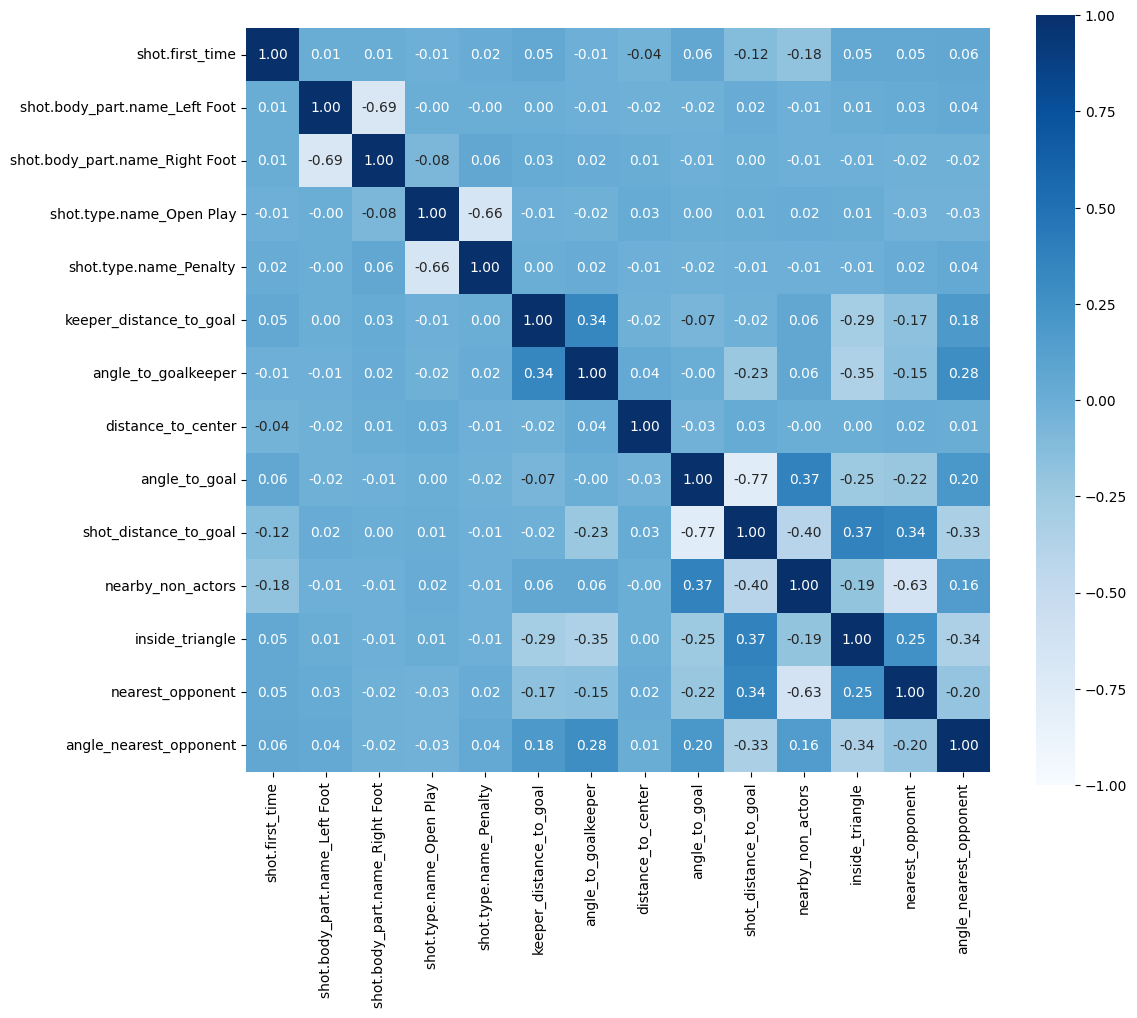

In [35]:
# Drop unnecessary columns for correlation analysis
corr_df = final_df.drop(['Goal','shot.type.name'], axis=1)
# Calculate the correlation matrix
corr_matrix = corr_df.corr(method='pearson').round(2)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', square=True, vmin=-1, vmax=1, fmt='.2f')
plt.show()

In [36]:
# Our target column is 'Goal'
X = final_df.drop('Goal', axis=1)
y = final_df['Goal']
stratified = final_df['shot.type.name']

# Stratify by the target column
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=stratified
)

# Then stratify again for validation and test split
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


In [37]:
# Drop the 'shot.type.name' column from the training, validation, and test sets
X_train = X_train.drop('shot.type.name', axis=1)
X_val = X_val.drop('shot.type.name', axis=1)
X_test = X_test.drop('shot.type.name', axis=1)

In [38]:
# Scale the numeric columns
scaler = StandardScaler()
numeric_columns = [ 'keeper_distance_to_goal',
       'angle_to_goalkeeper', 'distance_to_center', 'angle_to_goal',
       'shot_distance_to_goal', 'nearby_non_actors', 'inside_triangle',
       'nearest_opponent', 'angle_nearest_opponent']
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_val[numeric_columns] = scaler.transform(X_val[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

<Axes: title={'center': 'Feature Importances'}>

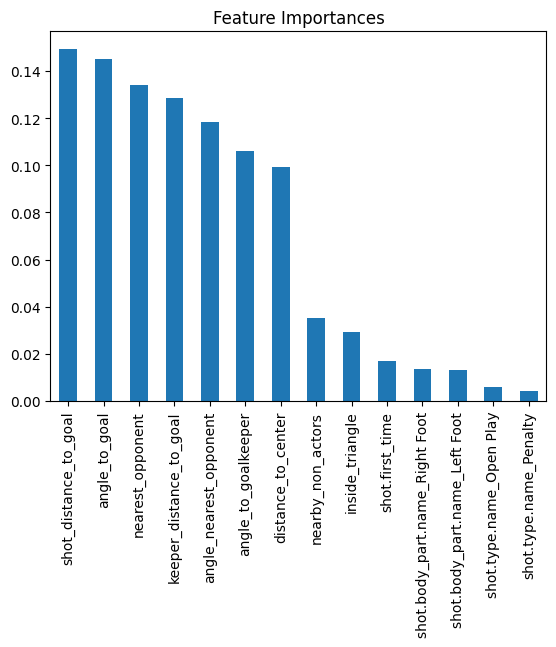

In [39]:
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).plot(kind='bar', title='Feature Importances')

In [40]:
# Normalize the data
final_df_to_normalize = final_df.drop(['Goal','shot.type.name'], axis=1)
normalized_df = final_df_to_normalize / final_df_to_normalize.mean()

# Print the variances of the normalized data
print(normalized_df.var())

shot.first_time                    2.189756
shot.body_part.name_Left Foot      2.259836
shot.body_part.name_Right Foot     0.927003
shot.type.name_Open Play           0.060640
shot.type.name_Penalty            38.052365
keeper_distance_to_goal            0.406654
angle_to_goalkeeper                0.545478
distance_to_center                 0.210046
angle_to_goal                      0.351943
shot_distance_to_goal              0.182762
nearby_non_actors                  0.944663
inside_triangle                    0.455005
nearest_opponent                   0.664861
angle_nearest_opponent             0.561111
dtype: float64


First Round of Model Evaluation

In [41]:
# Train a logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_val_proba = log_reg.predict_proba(X_val)[:, 1]  # Probability of positive class

In [42]:
brier_score = brier_score_loss(y_val, y_val_proba)
print("Brier Score:", brier_score)
importance = np.abs(log_reg.coef_[0])
importance_df = pd.DataFrame({'Feature': X_val.columns, 'Importance': importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)

Brier Score: 0.07313704833672413
                           Feature  Importance
9            shot_distance_to_goal    0.904793
12                nearest_opponent    0.533925
6              angle_to_goalkeeper    0.376827
8                    angle_to_goal    0.362911
2   shot.body_part.name_Right Foot    0.361958
5          keeper_distance_to_goal    0.343787
10               nearby_non_actors    0.284522
4           shot.type.name_Penalty    0.180376
1    shot.body_part.name_Left Foot    0.180292
11                 inside_triangle    0.160916
13          angle_nearest_opponent    0.094333
7               distance_to_center    0.044162
3         shot.type.name_Open Play    0.033434
0                  shot.first_time    0.007468


In [43]:
# Train a Random Forest model
rand_for = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rand_for.fit(X_train, y_train)
y_val_proba = rand_for.predict_proba(X_val)[:, 1]  # Probability of positive class

In [44]:
#Calculate the Brier score and feature importance
brier_score = brier_score_loss(y_val, y_val_proba)
print("Brier Score:", brier_score)

importances = model.feature_importances_
feature_names = X_val.columns  # or use whatever feature names you have
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)

Brier Score: 0.07502533692722373
                           Feature  Importance
9            shot_distance_to_goal    0.149347
8                    angle_to_goal    0.145098
12                nearest_opponent    0.133993
5          keeper_distance_to_goal    0.128679
13          angle_nearest_opponent    0.118344
6              angle_to_goalkeeper    0.106159
7               distance_to_center    0.099433
10               nearby_non_actors    0.035378
11                 inside_triangle    0.029417
0                  shot.first_time    0.016921
2   shot.body_part.name_Right Foot    0.013794
1    shot.body_part.name_Left Foot    0.013146
3         shot.type.name_Open Play    0.006057
4           shot.type.name_Penalty    0.004233


In [45]:
# Train an XGBoost model
xg = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xg.fit(X_train, y_train)
y_val_proba = xg.predict_proba(X_val)[:, 1]  # Probability of positive class

In [46]:
# Calculate the Brier score and feature importance
brier_score = brier_score_loss(y_val, y_val_proba)
print("Brier Score:", brier_score)

importance = xg.get_booster().get_score(importance_type='gain')  # or 'weight', 'cover'
importance_df = pd.DataFrame.from_dict(importance, orient='index', columns=['Importance'])
importance_df.index.name = 'Feature'
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)

Brier Score: 0.0758680104416542
                                Importance
Feature                                   
angle_to_goal                     5.576633
shot_distance_to_goal             2.787067
nearest_opponent                  2.737567
keeper_distance_to_goal           2.114331
angle_nearest_opponent            2.066939
inside_triangle                   1.999442
nearby_non_actors                 1.840273
angle_to_goalkeeper               1.793484
distance_to_center                1.706851
shot.body_part.name_Left Foot     1.641966
shot.first_time                   1.605208
shot.type.name_Penalty            1.563892
shot.type.name_Open Play          1.418852
shot.body_part.name_Right Foot    1.307556


In [47]:
# Train a Support Vector Classifier (SVC) model
svc = SVC(probability=True, kernel='rbf', random_state=42)
svc.fit(X_train, y_train)
y_val_proba = svc.predict_proba(X_val)[:, 1]  # Probability of positive class

In [48]:
# Calculate the Brier score and feature importance
brier_score = brier_score_loss(y_val, y_val_proba)
print("Brier Score:", brier_score)
result = permutation_importance(svc, X_val, y_val, n_repeats=30, random_state=42, scoring='neg_brier_score')
importance_df = pd.DataFrame({'Feature': X_val.columns, 'Importance': result.importances_mean})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)

Brier Score: 0.075023613490697
                           Feature  Importance
12                nearest_opponent    0.011457
8                    angle_to_goal    0.003456
9            shot_distance_to_goal    0.001643
13          angle_nearest_opponent    0.000828
0                  shot.first_time    0.000254
5          keeper_distance_to_goal    0.000240
2   shot.body_part.name_Right Foot    0.000223
11                 inside_triangle    0.000127
4           shot.type.name_Penalty    0.000018
6              angle_to_goalkeeper   -0.000048
3         shot.type.name_Open Play   -0.000130
7               distance_to_center   -0.000191
1    shot.body_part.name_Left Foot   -0.000336
10               nearby_non_actors   -0.000349


Second Round of Model Evaluation

In [49]:
# Train a Logistic Regression model with feature selection
X_train_log_reg_2 = X_train.drop(['shot.first_time', 'shot.type.name_Open Play', 'angle_nearest_opponent', 'distance_to_center'], axis=1)
X_val_log_reg_2 = X_val.drop(['shot.first_time', 'shot.type.name_Open Play', 'angle_nearest_opponent', 'distance_to_center'], axis=1)
log_reg = LogisticRegression()
log_reg.fit(X_train_log_reg_2, y_train)
y_val_proba = log_reg.predict_proba(X_val_log_reg_2)[:, 1]  # Probability of positive class
brier_score = brier_score_loss(y_val, y_val_proba)
print("Brier Score:", brier_score)
importance = np.abs(log_reg.coef_[0])
importance_df = pd.DataFrame({'Feature': X_val_log_reg_2.columns, 'Importance': importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)

Brier Score: 0.07324211649343372
                          Feature  Importance
6           shot_distance_to_goal    0.932777
9                nearest_opponent    0.523972
4             angle_to_goalkeeper    0.359956
1  shot.body_part.name_Right Foot    0.359538
5                   angle_to_goal    0.355685
3         keeper_distance_to_goal    0.344524
7               nearby_non_actors    0.288132
0   shot.body_part.name_Left Foot    0.195921
8                 inside_triangle    0.183038
2          shot.type.name_Penalty    0.133752


In [50]:
# Train a Random Forest model with feature selection
X_train_ran_for_2 = X_train.drop(['shot.type.name_Penalty', 'shot.type.name_Open Play'], axis=1)
X_val_ran_for_2 = X_val.drop(['shot.type.name_Penalty', 'shot.type.name_Open Play'], axis=1)


rand_for = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rand_for.fit(X_train_ran_for_2, y_train)
y_val_proba = rand_for.predict_proba(X_val_ran_for_2)[:, 1]  # Probability of positive class
brier_score = brier_score_loss(y_val, y_val_proba)
print("Brier Score:", brier_score)

importances = rand_for.feature_importances_
feature_names = X_val_ran_for_2.columns  # or use whatever feature names you have
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)



Brier Score: 0.0748032345013477
                           Feature  Importance
7            shot_distance_to_goal    0.176971
6                    angle_to_goal    0.167551
10                nearest_opponent    0.123083
3          keeper_distance_to_goal    0.114427
11          angle_nearest_opponent    0.107612
5               distance_to_center    0.104271
4              angle_to_goalkeeper    0.095129
9                  inside_triangle    0.039871
8                nearby_non_actors    0.032335
0                  shot.first_time    0.015173
2   shot.body_part.name_Right Foot    0.013825
1    shot.body_part.name_Left Foot    0.009755


In [51]:
# Train a Support Vector Classifier (SVC) model with feature selection
X_train_svc_2 = X_train.drop(['shot.type.name_Penalty', 'distance_to_center', 'shot.body_part.name_Left Foot', 'shot.body_part.name_Right Foot', 'shot.type.name_Open Play'], axis=1)
X_val_svc_2 = X_val.drop(['shot.type.name_Penalty', 'distance_to_center', 'shot.body_part.name_Left Foot', 'shot.body_part.name_Right Foot', 'shot.type.name_Open Play'], axis=1)

svc = SVC(probability=True, kernel='rbf', random_state=42)
svc.fit(X_train_svc_2, y_train)
y_val_proba = svc.predict_proba(X_val_svc_2)[:, 1]  # Probability of positive class
brier_score = brier_score_loss(y_val, y_val_proba)
print("Brier Score:", brier_score)
result = permutation_importance(svc, X_val_svc_2, y_val, n_repeats=30, random_state=42, scoring='neg_brier_score')
importance_df = pd.DataFrame({'Feature': X_train_svc_2.columns, 'Importance': result.importances_mean})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)



Brier Score: 0.07469311728023036
                   Feature  Importance
7         nearest_opponent    0.010569
3            angle_to_goal    0.004134
4    shot_distance_to_goal    0.001921
8   angle_nearest_opponent    0.000940
0          shot.first_time    0.000457
1  keeper_distance_to_goal    0.000369
5        nearby_non_actors    0.000043
6          inside_triangle    0.000011
2      angle_to_goalkeeper   -0.000352


Third Round of Model Evaluation

In [52]:
# Train a Support Vector Classifier (SVC) model with further feature selection
X_train_svc_3 =X_train_svc_2.drop(['angle_to_goalkeeper'], axis=1)
X_val_svc_3 =X_val_svc_2.drop(['angle_to_goalkeeper'], axis=1)

svc = SVC(probability=True, kernel='rbf', random_state=42)
svc.fit(X_train_svc_3, y_train)
y_val_proba = svc.predict_proba(X_val_svc_3)[:, 1]  # Probability of positive class
brier_score = brier_score_loss(y_val, y_val_proba)
print("Brier Score:", brier_score)
result = permutation_importance(svc, X_val_svc_3, y_val, n_repeats=30, random_state=42, scoring='neg_brier_score')
importance_df = pd.DataFrame({'Feature': X_val_svc_3.columns, 'Importance': result.importances_mean})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)

Brier Score: 0.0744790153629885
                   Feature  Importance
6         nearest_opponent    0.011241
2            angle_to_goal    0.004698
3    shot_distance_to_goal    0.002305
7   angle_nearest_opponent    0.001360
1  keeper_distance_to_goal    0.000668
0          shot.first_time    0.000390
4        nearby_non_actors    0.000316
5          inside_triangle    0.000238


Tuning the model with GridSearchCV

In [53]:
# Function to build and tune a model using GridSearchCV
def build_and_tune_model(model, param_grid, X, y):

    grid_search = GridSearchCV(
        model, 
        param_grid, 
        cv=5, 
        scoring='neg_brier_score', 
        n_jobs=-1
    )

    grid_search.fit(X, y)
    print("Best Parameters:", grid_search.best_params_)
    return grid_search


In [54]:
# Train and tune a Logistic Regression model
log_params = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'], 
    'solver': ['liblinear', 'saga']
    }

grid_log = build_and_tune_model(log_reg, log_params, X_train, y_train)

Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}


In [55]:
# Train and tune a Random Forest model
svc_params = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear']
}

grid_svc = build_and_tune_model(svc, svc_params, X_train_svc_3, y_train)

Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [56]:
# Train and tune an XGBoost model
rand_for_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2'],
}

grid_rand_for = build_and_tune_model(rand_for, rand_for_params, X_train, y_train)

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [57]:
# Train and tune a Support Vector Classifier (SVC) model
xg_params = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2],
}

random_search = RandomizedSearchCV(xg, param_distributions=xg_params, 
                                   n_iter=50, cv=5, scoring='accuracy', 
                                   verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 300, 500],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [1, 1.5, 2],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

Final Validation

In [58]:
#Final Validation of a Logistic Regression model
log_reg = LogisticRegression(C= 0.1, penalty='l1', solver='saga')
log_reg.fit(X_train_log_reg_2, y_train)
y_val_proba = log_reg.predict_proba(X_val_log_reg_2)[:, 1]  # Probability of positive class
brier_score = brier_score_loss(y_val, y_val_proba)
print("Brier Score:", brier_score)

Brier Score: 0.07244938765056182


In [59]:
# Final Validation of a Random Forest model
rand_for = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2)
rand_for.fit(X_train_ran_for_2, y_train)
y_val_proba = rand_for.predict_proba(X_val_ran_for_2)[:, 1]  # Probability of positive class
brier_score = brier_score_loss(y_val, y_val_proba)
print("Brier Score:", brier_score)

Brier Score: 0.0747448408133131


In [60]:
#Final Validation of an XGBoost model
svc = SVC(probability=True, kernel='rbf', random_state=42, C=10, gamma=0.1)
svc.fit(X_train_svc_3, y_train)
y_val_proba = svc.predict_proba(X_val_svc_3)[:, 1]  # Probability of positive class
brier_score = brier_score_loss(y_val, y_val_proba)
print("Brier Score:", brier_score)


Brier Score: 0.07408612119343796


In [61]:
# Final Validation of an XGBoost model
xg = XGBClassifier(probability=True, kernel='rbf', random_state=42,  n_estimators = 300 ,colsample_bytree= 0.6, eval_metric= 'logloss', C=1, gamma=0, learning_rate=0.01, max_depth = 3, min_child_weight=5, reg_alpha=0.1
, reg_lambda=1, subsample=0.6)
xg.fit(X_train, y_train)
y_val_proba = xg.predict_proba(X_val)[:, 1]  # Probability of positive class
brier_score = brier_score_loss(y_val, y_val_proba)
print("Brier Score:", brier_score)

Brier Score: 0.07243038460510119


Test on the Test Set

In [62]:
# Final Testing of a Logistic Regression model
X_test_log_reg_2 = X_test.drop(['shot.first_time', 'shot.type.name_Open Play', 'angle_nearest_opponent', 'distance_to_center'], axis=1)
y_test_proba = log_reg.predict_proba(X_test_log_reg_2)[:, 1]  # Probability of positive class
brier_score = brier_score_loss(y_test, y_test_proba)
print("Brier Score:", brier_score)

Brier Score: 0.07340246184083705


Comparison between our Model and StatsBomb's xG values

In [64]:
df_total_shots = merged_df[[
'Goal',
 'shot.statsbomb_xg',
 'shot.body_part.name_Left Foot',
 'shot.body_part.name_Right Foot',
 'shot.type.name_Penalty',
 'keeper_distance_to_goal',
 'angle_to_goalkeeper',
 'angle_to_goal',
 'shot_distance_to_goal',
 'nearby_non_actors',
 'inside_triangle', 
  'nearest_opponent']]


In [ ]:
#  Drop rows with NaN values
df_total_shots = df_total_shots.dropna()

In [66]:
# Scale the numeric columns
scaler = StandardScaler()
numeric_columns = [ 'keeper_distance_to_goal',
       'angle_to_goalkeeper',  'angle_to_goal',
       'shot_distance_to_goal', 'nearby_non_actors', 'inside_triangle',
       'nearest_opponent']
df_total_shots[numeric_columns] = scaler.fit_transform(df_total_shots[numeric_columns])

In [ ]:
# Define the features and target variable
X = df_total_shots.drop(['Goal', 'shot.statsbomb_xg'], axis=1)
y = df_total_shots['Goal']
y_statsbomb_xg = df_total_shots['shot.statsbomb_xg']

In [104]:
# Calculate the Brier score for the StatsBomb xG values
brier_score = brier_score_loss(y, y_statsbomb_xg)
print("Brier Score:", brier_score)

Brier Score: 0.07654871311736708


In [ ]:
# Predict using the Logistic Regression model
y_logreg_proba = log_reg.predict_proba(X)[:, 1] 

In [70]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_statsbomb_xg, y_logreg_proba))

# Calculate R² Score
r2 = r2_score(y_statsbomb_xg, y_logreg_proba)

# Print results
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 0.0868
R² Score: 0.7076


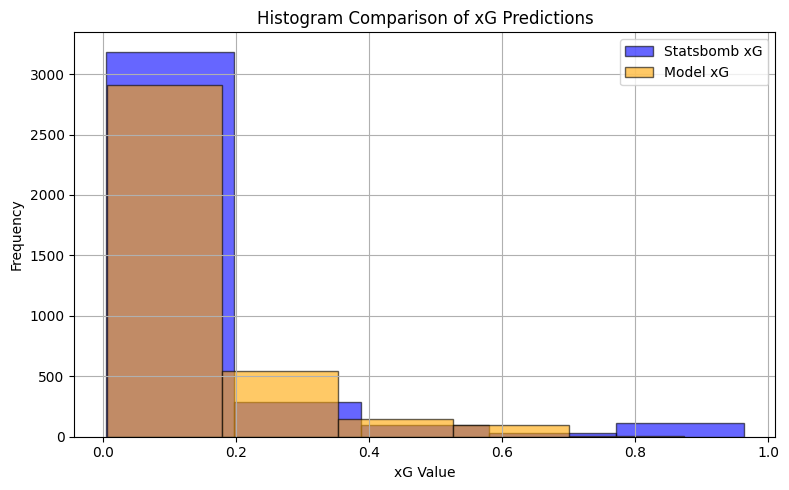

In [71]:
# Plot histograms
plt.figure(figsize=(8, 5))
plt.hist(y_statsbomb_xg, bins=5, alpha=0.6, label='Statsbomb xG', color='blue', edgecolor='black')
plt.hist(y_logreg_proba, bins=5, alpha=0.6, label='Model xG', color='orange', edgecolor='black')


# Add labels and legend
plt.title('Histogram Comparison of xG Predictions')
plt.xlabel('xG Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the mean xG values for both models
mean_model = y_logreg_proba.mean()
mean_benchmark = y_statsbomb_xg.mean()

print(f"Mean xG (Model): {mean_model:.4f}")
print(f"Mean xG (Statsbomb): {mean_benchmark:.4f}")


Mean xG (Model): 0.1251
Mean xG (Statsbomb): 0.1141


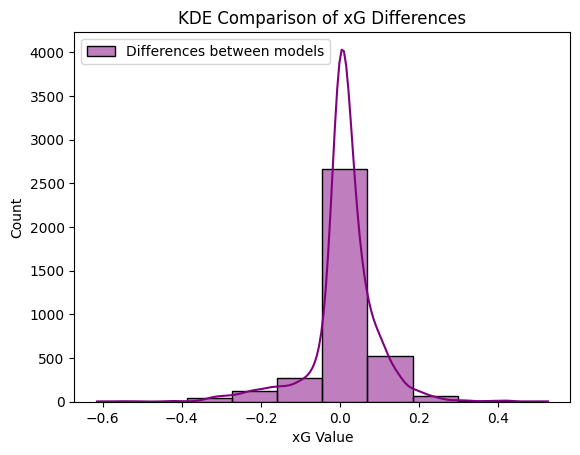

In [ ]:
# Plot KDE for the differences between the two models
sns.histplot(y_logreg_proba - y_statsbomb_xg,kde=True, bins=10, color='purple', label='Differences between models')
plt.title('KDE Comparison of xG Differences')
plt.xlabel('xG Value')
plt.legend()
plt.show()

In [ ]:
# Compute the p-value for the differences between the two models
t_stat, p_value = ttest_rel(y_logreg_proba, y_statsbomb_xg)
print(f"T-statistic: {t_stat:.4f}, p-value: {p_value:.15f}")


T-statistic: 7.8289, p-value: 0.000000000000006
